# Entrega Nº3

Grupo formado por:
 - Javier Asensio
 - Martín de las Heras
 - Daniel Serrano
 - Elena Tornero

En este caso vamos a trabajar con redes SOM. Para ello deberéis generar la clase SOM tal y como se ha visto en la sesión práctica.


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class SOM():
    def __init__(self, n1, n2, dim, epochs=1, lr=0.5, sigma=None, verbose=True):
        self.n1 = n1
        self.n2 = n2
        self.topography = []
        self.dim = dim
        self.num_iterations = epochs
        self.learned = False
        self.d = 0
        self.verbose = verbose

        if sigma is None:
            sigma = max(n1, n2) / 2.0
        else:
            sigma = sigma

        self.lr = lr
        self.learning_rate_0 = lr
        self.sigma = sigma
        self.sigma_0 = sigma

        if verbose:
            print("SOM created with dimensions: ", n1, n2)

        self.W = tf.random.normal([n1 * n2, dim])

        self.topography = np.array(list(self.neuron_location(n1, n2)))

    def training(self, x, i):
        n1 = self.n1
        n2 = self.n2

        d = tf.sqrt(tf.reduce_sum(tf.pow(self.W - tf.stack([x for i in range(n1 * n2)]), 2), 1))

        self.BMU_idx = tf.argmin(d, 0)
        self.d = d

        self.BMU_loc = self.topography[self.BMU_idx]

        lambda_coeff = self.num_iterations / self.sigma_0
        learning_rate = self.learning_rate_0 * np.exp(-i / lambda_coeff)
        sigma = self.sigma_0 * np.exp(-i / lambda_coeff)

        beta_ij = np.exp((-d**2)/(2*sigma**2))
        neighbs = [self.check_point(p[0], p[1], self.BMU_loc[0], self.BMU_loc[1], sigma) for p in self.topography]

        weight_multiplier = tf.math.multiply(beta_ij, neighbs)
        weight_multiplier = tf.math.multiply(learning_rate, weight_multiplier)

        delta_W = tf.subtract(tf.stack([x for i in range(n1 * n2)]), self.W)
        weight_multiplier = tf.stack([weight_multiplier for i in range(self.dim)], axis=1)
        update_value = tf.multiply(weight_multiplier, weight_multiplier)
        update_value = tf.multiply(weight_multiplier, delta_W)
        new_W = self.W + update_value
        self.W = new_W

    def fit(self, X):
        np.random.shuffle(X)
        X = tf.cast(X, tf.float32)
        for i in range(self.num_iterations):
            if self.verbose:
                if (i%10==0):
                    print('Step: ', i, ' of ', self.num_iterations, ' iterations.')
            for x in X:
                self.training(x, i)

        self.Wts = list(self.W)
        self.locations = list(self.topography)

        self.learned = True

    def check_point(self, x, y, center_x, center_y, radius):
        check = (x - center_x)**2 + (y - center_y)**2 < radius**2
        if check:
            return 1
        else:
            return 0
        
    def winner(self, x):
        if not self.learned:
            raise ValueError("SOM not trained yet.")
        return self.BMU_loc
    
    def neuron_location(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def map_vects(self, X):
        if not self.learned:
            raise ValueError("SOM not trained yet.")
        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self.Wts))],
                            key=lambda x: np.linalg.norm(vect - self.Wts[x]))
            to_return.append(self.locations[min_index])
        return to_return
    
    def distance_map(self):
        if not self.learned:
            raise ValueError("SOM not trained yet.")
        imd = []
        for index_p1 in range(self.n1*self.n2):
            dist = 0
            nums = 0
            for index_p2 in range(self.n1*self.n2):
                if ((index_p1 != index_p2) & self.check_point(self.topography[index_p1][0], self.topography[index_p1][1], self.topography[index_p2][0], self.topography[index_p2][1], 2) ==1):
                    dist += tf.sqrt(tf.reduce_sum(tf.pow(self.W[index_p1] - self.W[index_p2], 2))).numpy()
                    nums += 1.0
            imd.append(dist/nums)
        mapping = tf.reshape(imd, shape=(self.n1, self.n2)).numpy()

        return mapping

Una vez se tenga definida la clase, vamos a trabajar con el dataset credit_cards_applications. En este dataset se nos 
provee de información bancaria de distintos usuarios, representada a través de una serie de variables. Junto con ello
aparece una columna (Class) que indica si al usuario se le ha denegado (0) o aprobado (1) el crédito bancario.

Los campos son
- Id del cliente
- A1-A14 que son características (anonimizadas)
- Class que será la categoría

## Defina las variables con las que creará su SOM

Lea el fichero Credit_Card_Applications.csv y genere una variable X con las características A1-A14 y escalelas de forma que compartan valores máximos y mínimos (0-1) 

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
dataset = pd.read_csv('practica3-data.csv')
X = dataset.copy().drop(columns=['CustomerID', 'Class']).values
y = dataset.iloc[:, -1].values # Variable que dice si la application del customer fue aprobada o no

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1)) # Para que todos los valores estén entre 0 y 1
X = sc.fit_transform(X)

Cree una instancia de la clase recién creada SOM con 10x10 neuoronas y entrenela con los valores de X

In [66]:
som = SOM(10, 10, X.shape[1], epochs=100, lr=0.5, sigma=10.0, verbose=True)
som.fit(X)

SOM created with dimensions:  10 10
Step:  0  of  100  iterations.
Step:  10  of  100  iterations.
Step:  20  of  100  iterations.
Step:  30  of  100  iterations.
Step:  40  of  100  iterations.
Step:  50  of  100  iterations.
Step:  60  of  100  iterations.
Step:  70  of  100  iterations.
Step:  80  of  100  iterations.
Step:  90  of  100  iterations.


Una vez entrenadas, plotee el mapa de las distancias interneurona y considere como potenciales outliers aquellos cuya distancia interneurona sea mayor o igual al percentil 95.

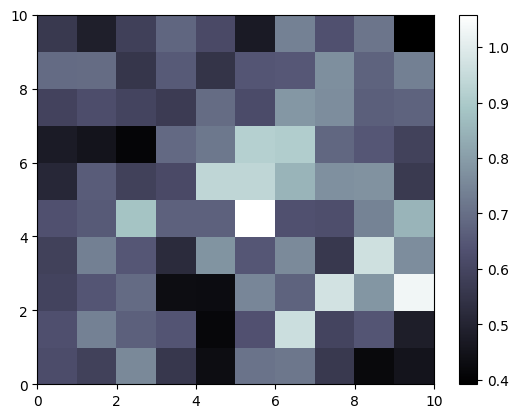

In [67]:
distance_matrix = som.distance_map().T
from matplotlib.pyplot import bone, pcolor, colorbar
bone()
pcolor(distance_matrix) # Para pintar el som. El .T para poner la matriz traspuesta. Lo que pinto es el MID de los nodos
colorbar();

De todos los valores de entrada, encuentre aquellos cuya BMU sea una de las neuronas 'sospechosas' e indique si se le concedió el crédito o no. Imprima dichos resultados por pantalla.

In [68]:
distance_list = distance_matrix.flatten()
threshold = np.quantile(distance_list, 0.95)
outliers = np.argwhere(distance_matrix > threshold)
outliers

array([[1, 6],
       [2, 7],
       [2, 9],
       [3, 8],
       [4, 5]], dtype=int64)

In [69]:
bmu = som.map_vects(X)

In [70]:
flagged = [x in outliers for x in bmu]
df = pd.DataFrame([y, flagged], ['Credit', 'Suspicious']).T
df.groupby(['Suspicious', 'Credit']).size()

Suspicious  Credit
False       0         126
            1          90
True        0         257
            1         217
dtype: int64